# Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras. 

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

C:\Users\sananand\AppData\Local\Continuum\miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

#TRAIN_PATH = '../input/stage1_train/'
#TEST_PATH = '../input/stage1_test/'

TRAIN_PATH = "C:/Public/ML/Kaggle/DataScienceBowl/stage1_train/"
TEST_PATH = "C:/Public/ML/Kaggle/DataScienceBowl/stage1_test/"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 64
random.seed = seed
np.random.seed = seed

In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
print(train_ids[0],'\n', test_ids[0])

00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552 
 0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


In [17]:
# Get the original image sizes for some of the random images in the training set
trainings = [train_ids[random.randint(0,len(train_ids))] for i in range(20)]
paths = [TRAIN_PATH+id_+'/images/'+id_+'.png' for id_ in trainings]
imsize = [imread(path).shape for path in paths]
for size in imsize:
    print(size,'\n') 

testings = [test_ids[random.randint(0,len(test_ids))] for i in range(20)]
paths_t = [TEST_PATH+id_+'/images/'+id_+'.png' for id_ in testings]
imsize_t = [imread(path).shape for path in paths_t]
for size in imsize_t:
    print(size,'\n')

(520, 696, 4) 

(520, 696, 4) 

(256, 256, 4) 

(256, 256, 4) 

(256, 256, 4) 

(256, 256, 4) 

(1024, 1024, 4) 

(256, 320, 4) 

(520, 696, 4) 

(256, 256, 4) 

(520, 696, 4) 

(360, 360, 4) 

(256, 256, 4) 

(256, 256, 4) 

(256, 256, 4) 

(256, 256, 4) 

(256, 320, 4) 

(360, 360, 4) 

(360, 360, 4) 

(256, 256, 4) 

(390, 239, 4) 

(256, 256, 4) 

(256, 256, 4) 

(256, 256, 3) 

(512, 680, 3) 

(260, 347, 4) 

(256, 256, 4) 

(524, 348, 3) 

(519, 253, 3) 

(256, 256, 4) 

(256, 256, 4) 

(256, 256, 3) 

(256, 256, 4) 

(256, 256, 4) 

(512, 680, 3) 

(520, 348, 3) 

(256, 256, 3) 

(520, 348, 3) 

(519, 162, 3) 

(512, 640, 4) 



# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [18]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 670/670 [02:44<00:00,  7.97it/s]


Getting and resizing test images ... 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 59.13it/s]


Done!


+ First for the Training iamges Above we get the features(X_train) and the labels (Y_train) , which are the images and the masks respectively
+ Second the same has been done for the test images, tests have only the images , there are no masks for the test images

Let's see if things look all right by drawing some random images and their associated masks.

C:\Users\sananand\AppData\Local\Continuum\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


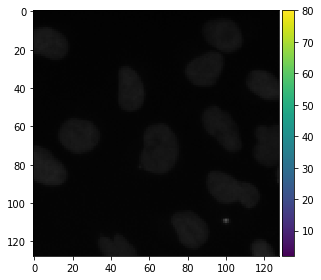

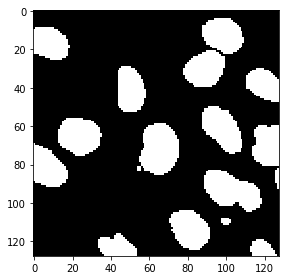

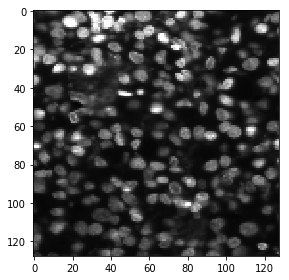

In [19]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Test images as well
it = random.randint(0, len(test_ids))
imshow(X_test[it])
plt.show()

Seems good!

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. **I'm by no means certain that this implementation is correct, though!** Any assistance in verifying this would be most welcome! 

*Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ... *

In [20]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.03):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [31]:
# add a inception model here
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# Build keras over a custom input tensor
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs) #Normalization 
print(s.shape)
base_model = InceptionV3(input_tensor = s, weights='imagenet', include_top=False)
x = base_model.output
#print(x.shape)
x = GlobalAveragePooling2D()(x)
print(x.shape)
#Full connected layer
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='sigmoid') (x)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

(?, 128, 128, 3)
(?, 2048)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
lambda_10 (Lambda)               (None, 128, 128, 3)   0           input_10[0][0]                   
____________________________________________________________________________________________________
conv2d_755 (Conv2D)              (None, 63, 63, 32)    864         lambda_10[0][0]                  
____________________________________________________________________________________________________
batch_normalization_753 (BatchNo (None, 63, 63, 32)    96          conv2d_755[0][0]                 
________________________________________________________________

____________________________________________________________________________________________________
activation_763 (Activation)      (None, 13, 13, 96)    0           batch_normalization_763[0][0]    
____________________________________________________________________________________________________
activation_764 (Activation)      (None, 13, 13, 32)    0           batch_normalization_764[0][0]    
____________________________________________________________________________________________________
mixed0 (Concatenate)             (None, 13, 13, 256)   0           activation_758[0][0]             
                                                                   activation_760[0][0]             
                                                                   activation_763[0][0]             
                                                                   activation_764[0][0]             
___________________________________________________________________________________________

conv2d_776 (Conv2D)              (None, 13, 13, 64)    76800       activation_773[0][0]             
____________________________________________________________________________________________________
conv2d_779 (Conv2D)              (None, 13, 13, 96)    82944       activation_776[0][0]             
____________________________________________________________________________________________________
conv2d_780 (Conv2D)              (None, 13, 13, 64)    18432       average_pooling2d_75[0][0]       
____________________________________________________________________________________________________
batch_normalization_772 (BatchNo (None, 13, 13, 64)    192         conv2d_774[0][0]                 
____________________________________________________________________________________________________
batch_normalization_774 (BatchNo (None, 13, 13, 64)    192         conv2d_776[0][0]                 
___________________________________________________________________________________________

conv2d_787 (Conv2D)              (None, 6, 6, 128)     114688      activation_784[0][0]             
____________________________________________________________________________________________________
conv2d_792 (Conv2D)              (None, 6, 6, 128)     114688      activation_789[0][0]             
____________________________________________________________________________________________________
batch_normalization_785 (BatchNo (None, 6, 6, 128)     384         conv2d_787[0][0]                 
____________________________________________________________________________________________________
batch_normalization_790 (BatchNo (None, 6, 6, 128)     384         conv2d_792[0][0]                 
____________________________________________________________________________________________________
activation_785 (Activation)      (None, 6, 6, 128)     0           batch_normalization_785[0][0]    
___________________________________________________________________________________________

conv2d_795 (Conv2D)              (None, 6, 6, 192)     147456      mixed4[0][0]                     
____________________________________________________________________________________________________
conv2d_798 (Conv2D)              (None, 6, 6, 192)     215040      activation_795[0][0]             
____________________________________________________________________________________________________
conv2d_803 (Conv2D)              (None, 6, 6, 192)     215040      activation_800[0][0]             
____________________________________________________________________________________________________
conv2d_804 (Conv2D)              (None, 6, 6, 192)     147456      average_pooling2d_77[0][0]       
____________________________________________________________________________________________________
batch_normalization_793 (BatchNo (None, 6, 6, 192)     576         conv2d_795[0][0]                 
___________________________________________________________________________________________

batch_normalization_812 (BatchNo (None, 6, 6, 192)     576         conv2d_814[0][0]                 
____________________________________________________________________________________________________
activation_803 (Activation)      (None, 6, 6, 192)     0           batch_normalization_803[0][0]    
____________________________________________________________________________________________________
activation_806 (Activation)      (None, 6, 6, 192)     0           batch_normalization_806[0][0]    
____________________________________________________________________________________________________
activation_811 (Activation)      (None, 6, 6, 192)     0           batch_normalization_811[0][0]    
____________________________________________________________________________________________________
activation_812 (Activation)      (None, 6, 6, 192)     0           batch_normalization_812[0][0]    
___________________________________________________________________________________________

____________________________________________________________________________________________________
conv2d_827 (Conv2D)              (None, 6, 6, 192)     147456      mixed7[0][0]                     
____________________________________________________________________________________________________
batch_normalization_825 (BatchNo (None, 6, 6, 192)     576         conv2d_827[0][0]                 
____________________________________________________________________________________________________
activation_825 (Activation)      (None, 6, 6, 192)     0           batch_normalization_825[0][0]    
____________________________________________________________________________________________________
conv2d_828 (Conv2D)              (None, 6, 6, 192)     258048      activation_825[0][0]             
____________________________________________________________________________________________________
batch_normalization_826 (BatchNo (None, 6, 6, 192)     576         conv2d_828[0][0]        

conv2d_839 (Conv2D)              (None, 2, 2, 192)     245760      average_pooling2d_80[0][0]       
____________________________________________________________________________________________________
batch_normalization_829 (BatchNo (None, 2, 2, 320)     960         conv2d_831[0][0]                 
____________________________________________________________________________________________________
activation_831 (Activation)      (None, 2, 2, 384)     0           batch_normalization_831[0][0]    
____________________________________________________________________________________________________
activation_832 (Activation)      (None, 2, 2, 384)     0           batch_normalization_832[0][0]    
____________________________________________________________________________________________________
activation_835 (Activation)      (None, 2, 2, 384)     0           batch_normalization_835[0][0]    
___________________________________________________________________________________________

activation_838 (Activation)      (None, 2, 2, 320)     0           batch_normalization_838[0][0]    
____________________________________________________________________________________________________
mixed9_1 (Concatenate)           (None, 2, 2, 768)     0           activation_840[0][0]             
                                                                   activation_841[0][0]             
____________________________________________________________________________________________________
concatenate_18 (Concatenate)     (None, 2, 2, 768)     0           activation_844[0][0]             
                                                                   activation_845[0][0]             
____________________________________________________________________________________________________
activation_846 (Activation)      (None, 2, 2, 192)     0           batch_normalization_846[0][0]    
___________________________________________________________________________________________

In [35]:
# Changed to have upconversion with Inceptionv3
# add a inception model here
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda 
from keras import backend as K

simple_cnn= Sequential()
simple_cnn.add(BatchNormalization(input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size=(3,3), padding='same'))
simple_cnn.add(Conv2D(8, kernel_size=(3,3), padding='same'))

simple_cnn.add(Conv2D(16, kernel_size=(3,3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(16, kernel_size=(3,3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(32, kernel_size=(3,3), dilation_rate=2, padding='same'))

simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs) #Normalization 
encoded_images = simple_cnn(s)
outputs = Dense(1, activation='sigmoid') (encoded_images)

cnnmodel = Model(inputs=[inputs], outputs=[outputs])
cnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_856 (Conv2D)          (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_857 (Conv2D)          (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_858 (Conv2D)          (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_859 (Conv2D)          (None, 128, 128, 16)      2320      
_________________________________________________________________
conv2d_860 (Conv2D)          (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_861 (Conv2D)          (None, 128, 128, 16)      528       
__________

In [36]:
# Do the Training 

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-mode-simplecnn-ep-100.h5', verbose=1, save_best_only=True)
results = cnnmodel.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 71s - loss: 0.7324 - mean_iou: 0.4004 - val_loss: 0.6963 - val_mean_iou: 0.4271
Epoch 2/100
603/603 [==============================] - 64s - loss: 0.7038 - mean_iou: 0.4313 - val_loss: 0.6796 - val_mean_iou: 0.4354
Epoch 3/100
603/603 [==============================] - 65s - loss: 0.6855 - mean_iou: 0.4375 - val_loss: 0.6612 - val_mean_iou: 0.4395
Epoch 4/100
603/603 [==============================] - 64s - loss: 0.6703 - mean_iou: 0.4412 - val_loss: 0.6455 - val_mean_iou: 0.4416
Epoch 5/100


603/603 [==============================] - 63s - loss: 0.6462 - mean_iou: 0.4432 - val_loss: 0.6246 - val_mean_iou: 0.4442
Epoch 6/100
603/603 [==============================] - 65s - loss: 0.6203 - mean_iou: 0.4455 - val_loss: 0.6173 - val_mean_iou: 0.4463
Epoch 7/100
603/603 [==============================] - 64s - loss: 0.6136 - mean_iou: 0.4465 - val_loss: 0.6053 - val_mean_iou: 0.4467
Epoch 8/100
603/603 [==============================] - 66s - loss: 0.5995 - mean_iou: 0.4471 - val_loss: 0.5914 - val_mean_iou: 0.4473
Epoch 9/100


603/603 [==============================] - 64s - loss: 0.5882 - mean_iou: 0.4476 - val_loss: 0.5795 - val_mean_iou: 0.4479
Epoch 10/100
603/603 [==============================] - 65s - loss: 0.5779 - mean_iou: 0.4482 - val_loss: 0.5687 - val_mean_iou: 0.4485
Epoch 11/100
603/603 [==============================] - 65s - loss: 0.5691 - mean_iou: 0.4487 - val_loss: 0.5580 - val_mean_iou: 0.4485
Epoch 12/100
603/603 [==============================] - 64s - loss: 0.5614 - mean_iou: 0.4484 - val_loss: 0.5519 - val_mean_iou: 0.4480
Epoch 13/100


603/603 [==============================] - 65s - loss: 0.5494 - mean_iou: 0.4478 - val_loss: 0.5386 - val_mean_iou: 0.4477
Epoch 14/100
603/603 [==============================] - 65s - loss: 0.5418 - mean_iou: 0.4475 - val_loss: 0.5346 - val_mean_iou: 0.4473
Epoch 15/100
603/603 [==============================] - 66s - loss: 0.5337 - mean_iou: 0.4471 - val_loss: 0.5202 - val_mean_iou: 0.4470
Epoch 16/100
603/603 [==============================] - 66s - loss: 0.5214 - mean_iou: 0.4469 - val_loss: 0.5101 - val_mean_iou: 0.4468
Epoch 17/100


603/603 [==============================] - 64s - loss: 0.5119 - mean_iou: 0.4468 - val_loss: 0.5013 - val_mean_iou: 0.4466
Epoch 18/100
603/603 [==============================] - 65s - loss: 0.5032 - mean_iou: 0.4466 - val_loss: 0.4921 - val_mean_iou: 0.4465
Epoch 19/100
603/603 [==============================] - 64s - loss: 0.4949 - mean_iou: 0.4465 - val_loss: 0.4841 - val_mean_iou: 0.4464
Epoch 20/100
603/603 [==============================] - 64s - loss: 0.4878 - mean_iou: 0.4464 - val_loss: 0.4757 - val_mean_iou: 0.4463
Epoch 21/100


603/603 [==============================] - 64s - loss: 0.4781 - mean_iou: 0.4463 - val_loss: 0.4673 - val_mean_iou: 0.4462
Epoch 22/100
603/603 [==============================] - 64s - loss: 0.4726 - mean_iou: 0.4462 - val_loss: 0.4623 - val_mean_iou: 0.4462
Epoch 23/100
603/603 [==============================] - 65s - loss: 0.4681 - mean_iou: 0.4461 - val_loss: 0.4551 - val_mean_iou: 0.4461
Epoch 24/100
603/603 [==============================] - 64s - loss: 0.4579 - mean_iou: 0.4460 - val_loss: 0.4478 - val_mean_iou: 0.4460
Epoch 25/100


603/603 [==============================] - 64s - loss: 0.4483 - mean_iou: 0.4460 - val_loss: 0.4376 - val_mean_iou: 0.4460
Epoch 26/100
603/603 [==============================] - 64s - loss: 0.4419 - mean_iou: 0.4459 - val_loss: 0.4302 - val_mean_iou: 0.4459
Epoch 27/100
603/603 [==============================] - 65s - loss: 0.4347 - mean_iou: 0.4459 - val_loss: 0.4312 - val_mean_iou: 0.4459
Epoch 28/100
603/603 [==============================] - 65s - loss: 0.4318 - mean_iou: 0.4459 - val_loss: 0.4309 - val_mean_iou: 0.4459
Epoch 29/100


603/603 [==============================] - 70s - loss: 0.4556 - mean_iou: 0.4457 - val_loss: 0.4186 - val_mean_iou: 0.4456
Epoch 30/100
603/603 [==============================] - 69s - loss: 0.4277 - mean_iou: 0.4456 - val_loss: 0.4113 - val_mean_iou: 0.4455
Epoch 31/100
603/603 [==============================] - 79s - loss: 0.4193 - mean_iou: 0.4455 - val_loss: 0.4066 - val_mean_iou: 0.4454
Epoch 32/100
603/603 [==============================] - 67s - loss: 0.4094 - mean_iou: 0.4454 - val_loss: 0.3954 - val_mean_iou: 0.4454
Epoch 33/100


603/603 [==============================] - 85s - loss: 0.4046 - mean_iou: 0.4454 - val_loss: 0.3900 - val_mean_iou: 0.4454
Epoch 34/100
603/603 [==============================] - 68s - loss: 0.4004 - mean_iou: 0.4454 - val_loss: 0.3871 - val_mean_iou: 0.4453
Epoch 35/100
603/603 [==============================] - 70s - loss: 0.3939 - mean_iou: 0.4453 - val_loss: 0.3815 - val_mean_iou: 0.4453
Epoch 36/100
603/603 [==============================] - 75s - loss: 0.3852 - mean_iou: 0.4454 - val_loss: 0.3731 - val_mean_iou: 0.4456
Epoch 37/100


603/603 [==============================] - 68s - loss: 0.3782 - mean_iou: 0.4459 - val_loss: 0.3673 - val_mean_iou: 0.4462
Epoch 38/100
603/603 [==============================] - 78s - loss: 0.3732 - mean_iou: 0.4465 - val_loss: 0.3628 - val_mean_iou: 0.4467
Epoch 39/100
603/603 [==============================] - 71s - loss: 0.3690 - mean_iou: 0.4470 - val_loss: 0.3576 - val_mean_iou: 0.4472
Epoch 40/100
603/603 [==============================] - 66s - loss: 0.3642 - mean_iou: 0.4475 - val_loss: 0.3526 - val_mean_iou: 0.4477
Epoch 41/100


603/603 [==============================] - 64s - loss: 0.3616 - mean_iou: 0.4480 - val_loss: 0.3491 - val_mean_iou: 0.4482
Epoch 42/100
603/603 [==============================] - 64s - loss: 0.3566 - mean_iou: 0.4484 - val_loss: 0.3470 - val_mean_iou: 0.4486
Epoch 43/100
603/603 [==============================] - 68s - loss: 0.3533 - mean_iou: 0.4488 - val_loss: 0.3414 - val_mean_iou: 0.4490
Epoch 44/100
603/603 [==============================] - 73s - loss: 0.3463 - mean_iou: 0.4492 - val_loss: 0.3354 - val_mean_iou: 0.4494
Epoch 45/100


603/603 [==============================] - 70s - loss: 0.3411 - mean_iou: 0.4497 - val_loss: 0.3308 - val_mean_iou: 0.4500
Epoch 46/100
603/603 [==============================] - 69s - loss: 0.3391 - mean_iou: 0.4504 - val_loss: 0.3298 - val_mean_iou: 0.4508
Epoch 47/100
603/603 [==============================] - 65s - loss: 0.3341 - mean_iou: 0.4512 - val_loss: 0.3228 - val_mean_iou: 0.4517
Epoch 48/100
603/603 [==============================] - 64s - loss: 0.3336 - mean_iou: 0.4520 - val_loss: 0.3203 - val_mean_iou: 0.4524
Epoch 49/100


603/603 [==============================] - 62s - loss: 0.3261 - mean_iou: 0.4528 - val_loss: 0.3153 - val_mean_iou: 0.4532
Epoch 50/100
603/603 [==============================] - 78s - loss: 0.3225 - mean_iou: 0.4536 - val_loss: 0.3130 - val_mean_iou: 0.4540
Epoch 51/100
603/603 [==============================] - 76s - loss: 0.3179 - mean_iou: 0.4543 - val_loss: 0.3074 - val_mean_iou: 0.4547
Epoch 52/100
603/603 [==============================] - 68s - loss: 0.3163 - mean_iou: 0.4551 - val_loss: 0.3048 - val_mean_iou: 0.4554
Epoch 53/100


603/603 [==============================] - 68s - loss: 0.3110 - mean_iou: 0.4557 - val_loss: 0.3004 - val_mean_iou: 0.4561
Epoch 54/100
603/603 [==============================] - 66s - loss: 0.3064 - mean_iou: 0.4564 - val_loss: 0.2981 - val_mean_iou: 0.4567
Epoch 55/100
603/603 [==============================] - 62s - loss: 0.3047 - mean_iou: 0.4572 - val_loss: 0.2964 - val_mean_iou: 0.4577
Epoch 56/100
603/603 [==============================] - 64s - loss: 0.3014 - mean_iou: 0.4582 - val_loss: 0.2913 - val_mean_iou: 0.4587
Epoch 57/100


603/603 [==============================] - 64s - loss: 0.2987 - mean_iou: 0.4592 - val_loss: 0.2880 - val_mean_iou: 0.4597
Epoch 58/100
603/603 [==============================] - 64s - loss: 0.2969 - mean_iou: 0.4602 - val_loss: 0.2881 - val_mean_iou: 0.4607
Epoch 59/100
603/603 [==============================] - 75s - loss: 0.2930 - mean_iou: 0.4612 - val_loss: 0.2825 - val_mean_iou: 0.4616
Epoch 60/100
603/603 [==============================] - 64s - loss: 0.2897 - mean_iou: 0.4621 - val_loss: 0.2807 - val_mean_iou: 0.4625
Epoch 61/100


603/603 [==============================] - 63s - loss: 0.2907 - mean_iou: 0.4629 - val_loss: 0.2774 - val_mean_iou: 0.4634
Epoch 62/100
603/603 [==============================] - 66s - loss: 0.2862 - mean_iou: 0.4638 - val_loss: 0.2796 - val_mean_iou: 0.4642
Epoch 63/100
603/603 [==============================] - 67s - loss: 0.2894 - mean_iou: 0.4646 - val_loss: 0.2742 - val_mean_iou: 0.4650
Epoch 64/100
603/603 [==============================] - 63s - loss: 0.2842 - mean_iou: 0.4654 - val_loss: 0.2716 - val_mean_iou: 0.4657
Epoch 65/100


603/603 [==============================] - 63s - loss: 0.2839 - mean_iou: 0.4661 - val_loss: 0.2730 - val_mean_iou: 0.4665
Epoch 66/100
603/603 [==============================] - 68s - loss: 0.2776 - mean_iou: 0.4670 - val_loss: 0.2641 - val_mean_iou: 0.4675
Epoch 67/100
603/603 [==============================] - 66s - loss: 0.2729 - mean_iou: 0.4681 - val_loss: 0.2625 - val_mean_iou: 0.4686
Epoch 68/100
603/603 [==============================] - 64s - loss: 0.2722 - mean_iou: 0.4692 - val_loss: 0.2600 - val_mean_iou: 0.4697
Epoch 69/100


603/603 [==============================] - 64s - loss: 0.2866 - mean_iou: 0.4701 - val_loss: 0.2807 - val_mean_iou: 0.4706
Epoch 70/100
603/603 [==============================] - 64s - loss: 0.2789 - mean_iou: 0.4710 - val_loss: 0.2759 - val_mean_iou: 0.4715
Epoch 71/100
603/603 [==============================] - 68s - loss: 0.2808 - mean_iou: 0.4719 - val_loss: 0.2572 - val_mean_iou: 0.4723
Epoch 72/100
603/603 [==============================] - 66s - loss: 0.2767 - mean_iou: 0.4727 - val_loss: 0.2807 - val_mean_iou: 0.4731
Epoch 73/100


603/603 [==============================] - 62s - loss: 0.2820 - mean_iou: 0.4735 - val_loss: 0.2604 - val_mean_iou: 0.4739
Epoch 74/100
603/603 [==============================] - 62s - loss: 0.2644 - mean_iou: 0.4743 - val_loss: 0.2521 - val_mean_iou: 0.4748
Epoch 75/100
603/603 [==============================] - 63s - loss: 0.2584 - mean_iou: 0.4752 - val_loss: 0.2487 - val_mean_iou: 0.4756
Epoch 76/100
603/603 [==============================] - 62s - loss: 0.2563 - mean_iou: 0.4761 - val_loss: 0.2451 - val_mean_iou: 0.4765
Epoch 77/100


603/603 [==============================] - 61s - loss: 0.2514 - mean_iou: 0.4769 - val_loss: 0.2432 - val_mean_iou: 0.4773
Epoch 78/100
603/603 [==============================] - 61s - loss: 0.2507 - mean_iou: 0.4778 - val_loss: 0.2410 - val_mean_iou: 0.4783
Epoch 79/100
603/603 [==============================] - 62s - loss: 0.2511 - mean_iou: 0.4788 - val_loss: 0.2385 - val_mean_iou: 0.4794
Epoch 80/100
603/603 [==============================] - 64s - loss: 0.2488 - mean_iou: 0.4799 - val_loss: 0.2375 - val_mean_iou: 0.4805
Epoch 81/100


603/603 [==============================] - 67s - loss: 0.2437 - mean_iou: 0.4810 - val_loss: 0.2359 - val_mean_iou: 0.4815
Epoch 82/100
603/603 [==============================] - 66s - loss: 0.2444 - mean_iou: 0.4821 - val_loss: 0.2341 - val_mean_iou: 0.4826
Epoch 83/100
603/603 [==============================] - 66s - loss: 0.2408 - mean_iou: 0.4831 - val_loss: 0.2325 - val_mean_iou: 0.4836
Epoch 84/100
603/603 [==============================] - 65s - loss: 0.2408 - mean_iou: 0.4841 - val_loss: 0.2295 - val_mean_iou: 0.4846
Epoch 85/100


603/603 [==============================] - 75s - loss: 0.2376 - mean_iou: 0.4851 - val_loss: 0.2293 - val_mean_iou: 0.4856
Epoch 86/100
603/603 [==============================] - 67s - loss: 0.2382 - mean_iou: 0.4860 - val_loss: 0.2265 - val_mean_iou: 0.4865
Epoch 87/100
603/603 [==============================] - 71s - loss: 0.2358 - mean_iou: 0.4870 - val_loss: 0.2258 - val_mean_iou: 0.4874
Epoch 88/100
603/603 [==============================] - 71s - loss: 0.2394 - mean_iou: 0.4879 - val_loss: 0.2264 - val_mean_iou: 0.4883
Epoch 89/100


603/603 [==============================] - 72s - loss: 0.2326 - mean_iou: 0.4888 - val_loss: 0.2227 - val_mean_iou: 0.4893
Epoch 90/100
603/603 [==============================] - 82s - loss: 0.2312 - mean_iou: 0.4899 - val_loss: 0.2209 - val_mean_iou: 0.4905
Epoch 91/100
603/603 [==============================] - 71s - loss: 0.2299 - mean_iou: 0.4910 - val_loss: 0.2194 - val_mean_iou: 0.4916
Epoch 92/100
603/603 [==============================] - 70s - loss: 0.2282 - mean_iou: 0.4922 - val_loss: 0.2188 - val_mean_iou: 0.4927
Epoch 93/100


603/603 [==============================] - 71s - loss: 0.2262 - mean_iou: 0.4932 - val_loss: 0.2163 - val_mean_iou: 0.4938
Epoch 94/100
603/603 [==============================] - 63s - loss: 0.2257 - mean_iou: 0.4943 - val_loss: 0.2168 - val_mean_iou: 0.4948
Epoch 95/100
603/603 [==============================] - 63s - loss: 0.2262 - mean_iou: 0.4953 - val_loss: 0.2139 - val_mean_iou: 0.4958
Epoch 96/100
603/603 [==============================] - 64s - loss: 0.2214 - mean_iou: 0.4964 - val_loss: 0.2121 - val_mean_iou: 0.4969
Epoch 97/100


603/603 [==============================] - 68s - loss: 0.2231 - mean_iou: 0.4973 - val_loss: 0.2118 - val_mean_iou: 0.4978
Epoch 98/100
603/603 [==============================] - 64s - loss: 0.2217 - mean_iou: 0.4983 - val_loss: 0.2100 - val_mean_iou: 0.4988
Epoch 99/100
603/603 [==============================] - 64s - loss: 0.2225 - mean_iou: 0.4993 - val_loss: 0.2109 - val_mean_iou: 0.4997
Epoch 100/100
603/603 [==============================] - 67s - loss: 0.2211 - mean_iou: 0.5002 - val_loss: 0.2097 - val_mean_iou: 0.5006


# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [11]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs) #Normalization 

# Upconversion
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

#Downconversion
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 128, 128, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_20 (Conv2D)               (None, 128, 128, 16)  448         lambda_2[0][0]                   
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 128, 128, 16)  0           conv2d_20[0][0]                  
___________________________________________________________________________________________

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [20]:
# Fit model , #change epoch to [10, 20, 30, 50, 70]
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-ep-100.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 536 samples, validate on 134 samples
Epoch 1/100
536/536 [==============================] - 146s - loss: 0.0886 - mean_iou: 0.8038 - val_loss: 0.0820 - val_mean_iou: 0.8332
Epoch 2/100
536/536 [==============================] - 151s - loss: 0.0866 - mean_iou: 0.8346 - val_loss: 0.0779 - val_mean_iou: 0.8344
Epoch 3/100
536/536 [==============================] - 135s - loss: 0.0885 - mean_iou: 0.8341 - val_loss: 0.0824 - val_mean_iou: 0.8342
Epoch 4/100
536/536 [==============================] - 140s - loss: 0.0856 - mean_iou: 0.8331 - val_loss: 0.0767 - val_mean_iou: 0.8339
Epoch 5/100
536/536 [==============================] - 135s - loss: 0.0853 - mean_iou: 0.8350 - val_loss: 0.0791 - val_mean_iou: 0.8347
Epoch 6/100
536/536 [==============================] - 136s - loss: 0.0835 - mean_iou: 0.8347 - val_loss: 0.0743 - val_mean_iou: 0.8352
Epoch 7/100
536/536 [==============================] - 138s - loss: 0.0806 - mean_iou: 0.8359 - val_loss: 0.0721 - val_mean_iou: 0.8364
Ep

536/536 [==============================] - 136s - loss: 0.0776 - mean_iou: 0.8381 - val_loss: 0.0682 - val_mean_iou: 0.8387
Epoch 10/100
536/536 [==============================] - 134s - loss: 0.0770 - mean_iou: 0.8389 - val_loss: 0.0675 - val_mean_iou: 0.8395
Epoch 11/100
536/536 [==============================] - 134s - loss: 0.0753 - mean_iou: 0.8405 - val_loss: 0.0737 - val_mean_iou: 0.8407
Epoch 12/100
536/536 [==============================] - 140s - loss: 0.0766 - mean_iou: 0.8411 - val_loss: 0.0722 - val_mean_iou: 0.8413
Epoch 13/100
536/536 [==============================] - 137s - loss: 0.0748 - mean_iou: 0.8414 - val_loss: 0.0660 - val_mean_iou: 0.8419
Epoch 14/100
536/536 [==============================] - 138s - loss: 0.0736 - mean_iou: 0.8423 - val_loss: 0.0684 - val_mean_iou: 0.8428
Epoch 15/100
536/536 [==============================] - 137s - loss: 0.0747 - mean_iou: 0.8432 - val_loss: 0.0684 - val_mean_iou: 0.8436
Epoch 16/100
536/536 [==============================] 

536/536 [==============================] - 137s - loss: 0.0755 - mean_iou: 0.8440 - val_loss: 0.0688 - val_mean_iou: 0.8442
Epoch 18/100
536/536 [==============================] - 144s - loss: 0.0705 - mean_iou: 0.8447 - val_loss: 0.0681 - val_mean_iou: 0.8450
Epoch 19/100
536/536 [==============================] - 141s - loss: 0.0699 - mean_iou: 0.8455 - val_loss: 0.0638 - val_mean_iou: 0.8458
Epoch 20/100
536/536 [==============================] - 141s - loss: 0.0699 - mean_iou: 0.8461 - val_loss: 0.0619 - val_mean_iou: 0.8465
Epoch 21/100
536/536 [==============================] - 136s - loss: 0.0714 - mean_iou: 0.8469 - val_loss: 0.0678 - val_mean_iou: 0.8471
Epoch 22/100
536/536 [==============================] - 137s - loss: 0.0699 - mean_iou: 0.8472 - val_loss: 0.0690 - val_mean_iou: 0.8475
Epoch 23/100
536/536 [==============================] - 136s - loss: 0.0688 - mean_iou: 0.8477 - val_loss: 0.0641 - val_mean_iou: 0.8479
Epoch 24/100
536/536 [==============================] 

536/536 [==============================] - 136s - loss: 0.0683 - mean_iou: 0.8487 - val_loss: 0.0659 - val_mean_iou: 0.8490
Epoch 26/100
536/536 [==============================] - 135s - loss: 0.0680 - mean_iou: 0.8493 - val_loss: 0.0654 - val_mean_iou: 0.8495
Epoch 00025: early stopping


All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [37]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-mode-simplecnn-ep-100.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 2s     


C:\Users\sananand\AppData\Local\Continuum\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


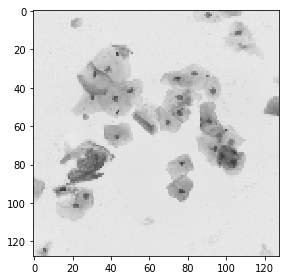

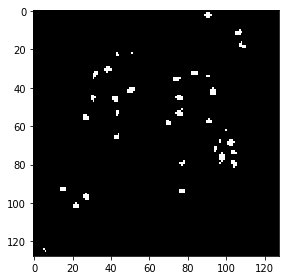

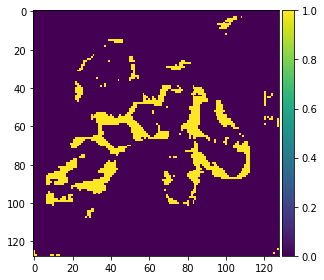

In [38]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

C:\Users\sananand\AppData\Local\Continuum\miniconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


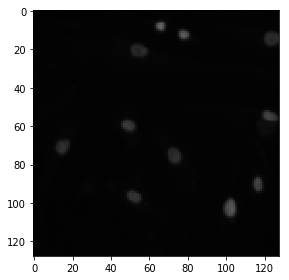

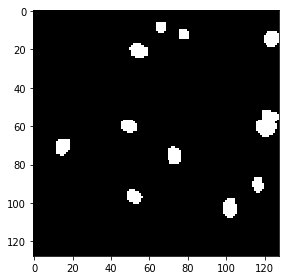

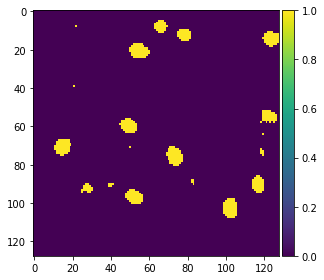

In [39]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [40]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [41]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [42]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-3rd.csv', index=False)

###### This scored 0.226 on the LB for me.  - for the 1st submission 


You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**

LB score history:
- Version 7: 0.277 LB